In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
import os

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        self.conv5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(256 * 4 * 4, 512)  # Adjusted size
        self.fc2 = nn.Linear(512, 3)
        
        self.dropout = nn.Dropout(0.2)  # Reduce if needed

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = self.pool(F.relu(self.bn4(self.conv4(x))))
        x = self.pool(F.relu(self.bn5(self.conv5(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

In [7]:
transform_train = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.RandomHorizontalFlip(p=0.15),
    transforms.RandomRotation(15),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.25),
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.2)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


# Validation transformations (NO augmentations)
transform_val = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to match training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load dataset (replace 'train_data_path' and 'val_data_path' with actual paths)
train_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/train', transform=transform_train)
val_dataset = datasets.ImageFolder(root='MLDL_Data_Face-1/val', transform=transform_val)

from sklearn.model_selection import StratifiedKFold
from torch.utils.data import Subset
import numpy as np

# Define number of folds
num_folds = 5

# Extract image paths and labels from train_dataset
image_paths = np.array(train_dataset.imgs)  # Full dataset image paths
labels = np.array(train_dataset.targets)  # Corresponding labels

# Set up Stratified K-Fold
skf = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import StratifiedKFold

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True  # Speed up training if inputs are same size

# Compute class weights once before training (not in every fold)
class_counts = [4541, 5453, 4945]
class_weights = torch.FloatTensor([sum(class_counts) / count for count in class_counts]).to(device)

scaler = torch.amp.GradScaler('cuda')  # Use mixed precision for speedup

train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

# Perform cross-validation
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"Training on fold {fold + 1}/{num_folds}...")

    train_subset = Subset(train_dataset, train_idx)
    val_subset = Subset(train_dataset, val_idx)

    train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=32, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

    patience = 6
    best_val_loss = float('inf')
    counter = 0

    num_epochs = 50
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            
            with torch.amp.autocast('cuda'):  # Enable Mixed Precision
                outputs = model(images)
                loss = criterion(outputs, labels)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)

                with torch.amp.autocast('cuda'):
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        # Early Stopping
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            counter = 0
        else:
            counter += 1
            if counter >= patience:
                print("Early stopping triggered.")
                break

        scheduler.step()


Training on fold 1/5...
Epoch [1/50], Train Loss: 1.0760, Train Acc: 41.07%, Val Loss: 1.0327, Val Acc: 43.41%
Epoch [2/50], Train Loss: 0.9693, Train Acc: 50.74%, Val Loss: 1.0587, Val Acc: 46.79%
Epoch [3/50], Train Loss: 0.8547, Train Acc: 58.84%, Val Loss: 0.7906, Val Acc: 64.36%
Epoch [4/50], Train Loss: 0.7534, Train Acc: 65.16%, Val Loss: 0.7342, Val Acc: 64.83%
Epoch [5/50], Train Loss: 0.6815, Train Acc: 69.57%, Val Loss: 0.7444, Val Acc: 65.19%
Epoch [6/50], Train Loss: 0.5852, Train Acc: 74.55%, Val Loss: 0.5772, Val Acc: 75.74%
Epoch [7/50], Train Loss: 0.5395, Train Acc: 77.65%, Val Loss: 0.4843, Val Acc: 80.56%
Epoch [8/50], Train Loss: 0.5060, Train Acc: 78.40%, Val Loss: 0.5155, Val Acc: 78.58%
Epoch [9/50], Train Loss: 0.4853, Train Acc: 79.99%, Val Loss: 0.5188, Val Acc: 77.31%
Epoch [10/50], Train Loss: 0.4594, Train Acc: 80.82%, Val Loss: 0.4396, Val Acc: 81.93%
Epoch [11/50], Train Loss: 0.4221, Train Acc: 82.81%, Val Loss: 0.4018, Val Acc: 83.80%
Epoch [12/50], Tr

In [9]:
timestamp = time.strftime('%Y%m%d_%H%M%S')
checkpoint_filename = f'checkpoint_epoch_{epoch}_{timestamp}.pth'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': val_loss,
}, checkpoint_filename)


In [10]:
""" checkpoint_path = 'checkpoint_epoch_1_20250320_171718.pth'
checkpoint = torch.load(checkpoint_path)
model.load_state_dict(checkpoint['model_state_dict'])
 """

" checkpoint_path = 'checkpoint_epoch_1_20250320_171718.pth'\ncheckpoint = torch.load(checkpoint_path)\nmodel.load_state_dict(checkpoint['model_state_dict'])\n "

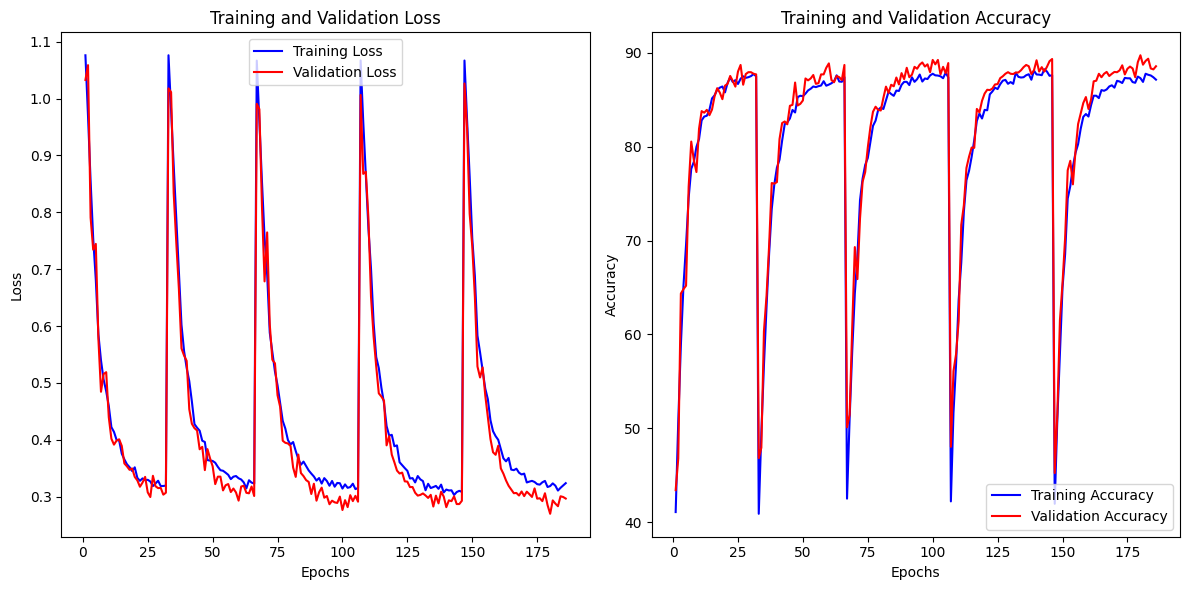

In [11]:
import matplotlib.pyplot as plt

# Example: Training and Validation loss over epochs
epochs = range(1, len(train_losses) + 1)

# Plot loss
plt.figure(figsize=(12, 6))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='blue')
plt.plot(epochs, val_accuracies, label='Validation Accuracy', color='red')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Show the plots
plt.tight_layout()
plt.show()
